# Simulación del filtro

Se ha hecho un filtro de con el código de C:

```c
posCnt = EQep1Regs.QPOSCNT;
Delta_posCnt = (int32)posCnt - (int32)posCnt_ant;
if (Delta_posCnt < -QEPCNTMAX/2){
     Delta_posCnt +=  QEPCNTMAX;
} else if(Delta_posCnt > QEPCNTMAX/2){
     Delta_posCnt -= QEPCNTMAX;
}
wm_k =  (0.8 * wm_k + 0.2 * (float)(butterworthDelta_posCnt) * tick_to_radps);
posCnt_ant = posCnt;
```

No se ha conseguido poner en marcha en la bancada de la escuela, por lo que se quiere simular el algoritmo para ver si se ha cometido algún error.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integ

Algunas variables útiles

In [2]:
frec = np.int32(20e3)
QEPCNTMAX: np.int32 = 4 * 2500

Perfil de velocidad basado un sistema de segundo orden con sobreoscilación

In [3]:
def vel(t: [np.float64])-> [np.float64]:
    phi: np.float64 = 14
    alpha: np.float64 = 0
    b: np.float64 = 3.2
    G: np.float64 = 20 
    a = 1/np.cos(alpha)
    return G * (1 - a*np.exp(-b * t)*(np.cos(phi * t + alpha)))

Gráfica de la velocidad

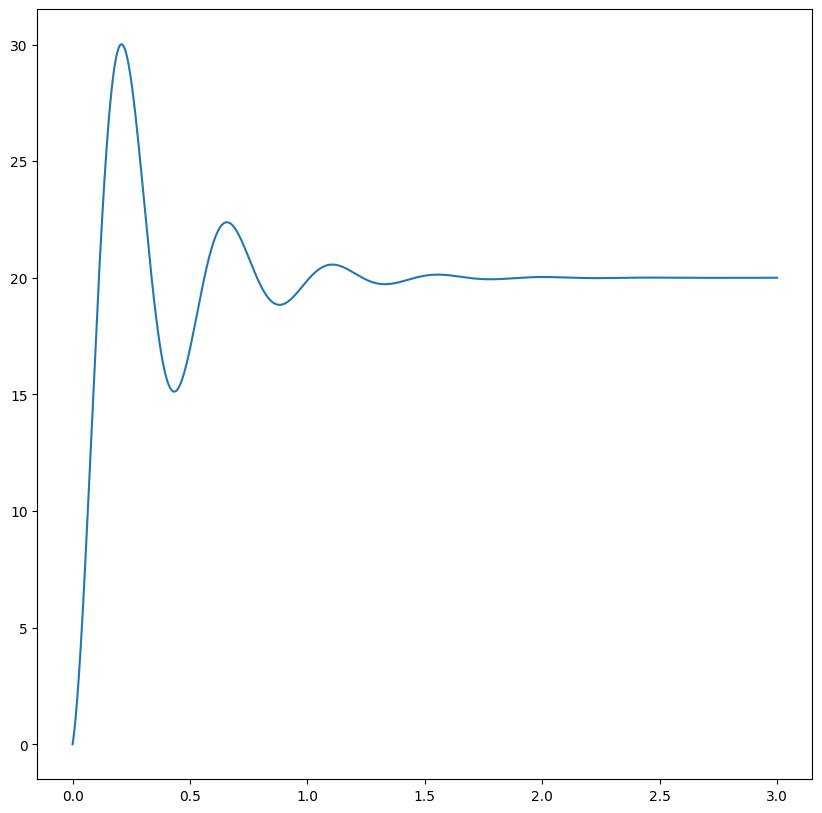

In [4]:
t = np.linspace(0, 3, int(frec)*3 + 1)
fig_vel_ideal = plt.figure(figsize=(10,10)) 
ideal_vel = vel(t)
plt.plot(t, ideal_vel)
fig_vel_ideal.savefig('vel_ideal.eps',bbox_inches="tight")

La posición es la integral de la velocidad, modificada para que esté en el rango $0 \leq x < 10000$

In [5]:
def position(x: np.float64) -> np.int32:
    """Simula lo que devolvería el encoder."""
    return np.int32(
        (QEPCNTMAX * integ.quad(vel, 0, x)[0]) / (2 * np.pi)
    ) % QEPCNTMAX


Gráfica de la posición

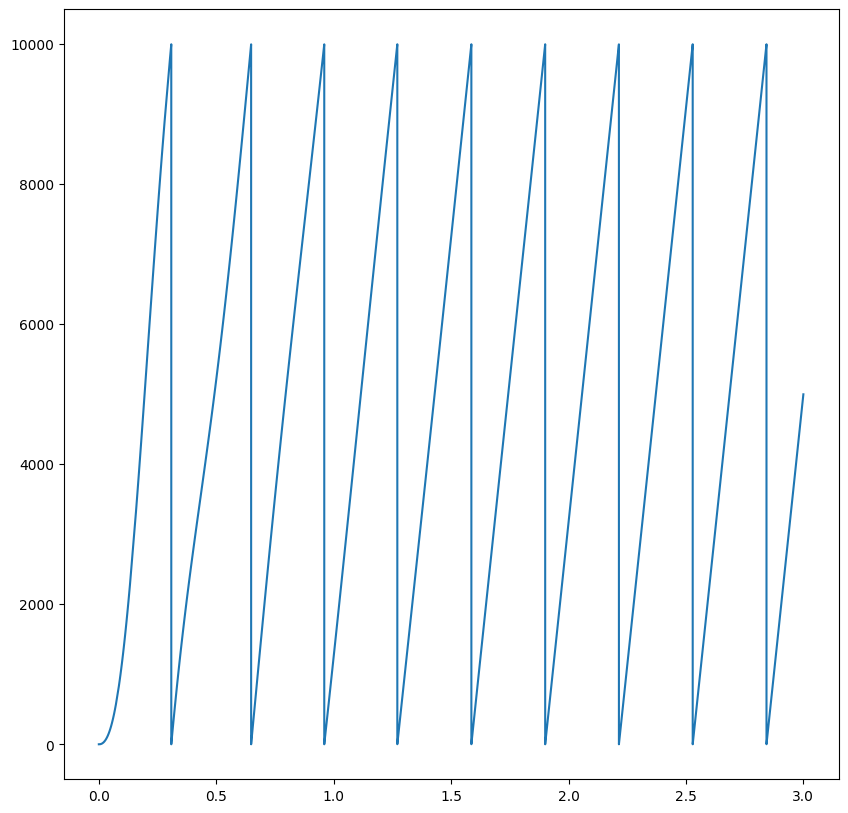

In [6]:
position_at_t = np.array([position(t_) for t_ in t])
fig_pos = plt.figure(figsize=(10,10))
plt.plot(t, position_at_t)
fig_pos.savefig('posicion.eps', bbox_inches="tight")

Implementación en python del código en C

In [7]:
class FilterCalc():
    """Clase que implementa el cálculo de la velocidad.

    Para ello utiliza variables internas de la clase para tener 'memoria' de la
    última iteración.
    """

    def __init__(self, frec, measure_percent):
        """Crea el contexto del main de C, con las variables que se usarían."""
        self.butter_params = (np.float32(1.0 - measure_percent),
                              np.float32(measure_percent))
        self.posCnt_ant = np.int32(0)
        self.speed = np.float32(0)
        self.tick_to_radps: np.float32 = (
            frec * 2.0 * 3.141592) / np.float64(QEPCNTMAX)

    def recalc(self, posCnt: np.int32) -> np.float32:
        """Calcula la velocidad."""
        Delta_posCnt = posCnt - self.posCnt_ant
        if Delta_posCnt < -QEPCNTMAX/2:
            Delta_posCnt += QEPCNTMAX
        elif Delta_posCnt > QEPCNTMAX/2:
            Delta_posCnt -= QEPCNTMAX
        self.speed = (self.butter_params[0] * self.speed
                      + (self.butter_params[1]
                         * Delta_posCnt
                         * self.tick_to_radps))
        self.posCnt_ant = posCnt
        return self.speed

Gráfica de la velocidad

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


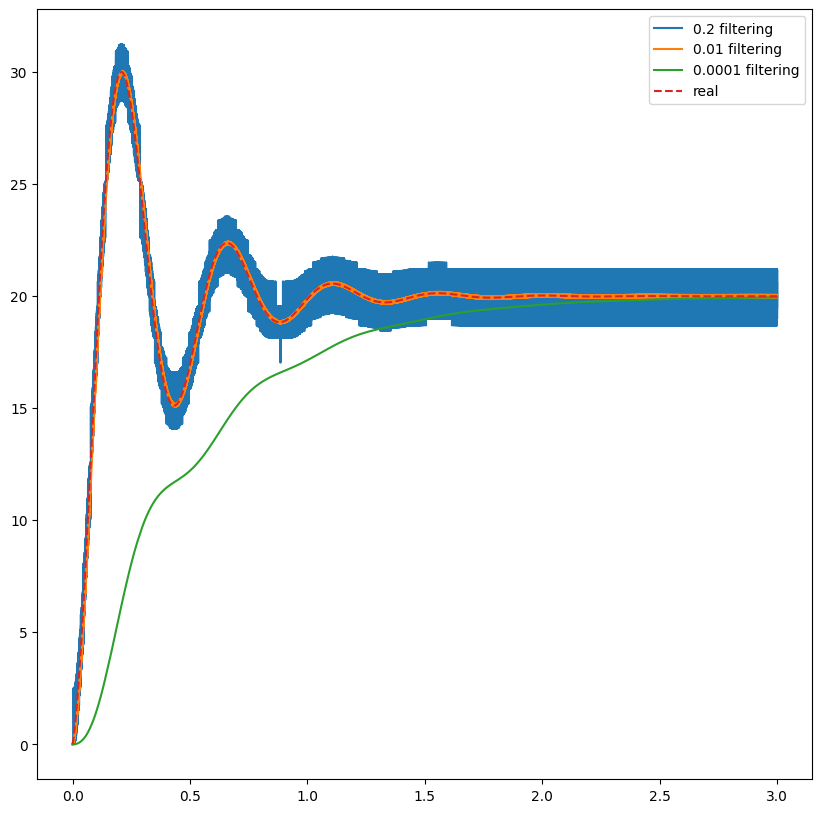

In [8]:
speed_filter = FilterCalc(frec, 0.2)
speed_calcs = np.array([speed_filter.recalc(x) for x in position_at_t])
fig = plt.figure(figsize=(10,10))
plt.plot(t, speed_calcs)
speed_filter_2 = FilterCalc(frec, 0.01)
speed_calcs_2 = np.array([speed_filter_2.recalc(x) for x in position_at_t])
plt.plot(t, speed_calcs_2)
speed_filter_3 = FilterCalc(frec, 0.0001)
speed_calcs_3 = np.array([speed_filter_3.recalc(x) for x in position_at_t])
plt.plot(t, speed_calcs_3)
plt.plot(t, ideal_vel, linestyle = '--')
plt.legend(['0.2 filtering', '0.01 filtering', '0.0001 filtering', 'real'])
fig.savefig('velocidades.eps', bbox_inches="tight")